#Kernel Non-negative Tensor Factorization

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io as sio #to load mat files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<h2>1. Loading dataset CMU Faces</h2>

$\mathcal{TF}\in\mathbb{R}_+^{30\times11\times21\times1024}$

In [1]:
sio.whosmat('../datasets/CMU(30x11x21x1024).mat')

NameError: name 'sio' is not defined

In [4]:
matTF = sio.loadmat('../datasets/CMU(30x11x21x1024).mat')#loading tensor of formatted faces' images

In [5]:
TF = matTF['FullTensor']

In [6]:
TF.shape

(30, 11, 21, 1024)

1.1 Tensor matrization

$MF\in\mathbb{R}_+^{6930\times1024}$

In [7]:
MF = np.reshape(TF,(30*11*21,1024))

Some images which compound the tensor:

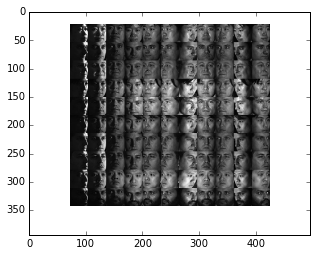

In [8]:
img=mpimg.imread('../datasets/faces_sample.png')
imgplot = plt.imshow(img)

<h3> 1.1 Preprocessing to incomplete data</h3>

In [8]:
rt_obinc = 0.3 # rate of objects incomplete
rt_incpob = 0.5 # rate of minimun elements (attributes or variables) incomplete for each object
idx_inc = np.sort(np.random.choice(MF.shape[0], MF.shape[0]*rt_obinc, replace=False))
idx_v = np.ones(MF.shape[0])
idx_v[idx_inc] = 0
idx_s = np.vstack((idx_v,idx_v)).repeat([1,MF.shape[1]-1],0).T
idx_com = np.arange(0,MF.shape[0]-1)
idx_com = np.delete(idx_com, idx_inc)
data_i = MF[idx_inc]#subset with incomplete elements
data_c = MF[idx_com]#subset with complete elements

<matplotlib.colorbar.Colorbar instance at 0x7fc96d1e0518>

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


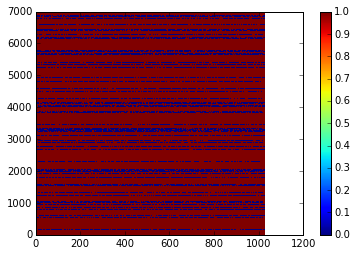

In [9]:
idx_s2 = np.copy(idx_s) # idx_s2 could have partially incomplete objects
for i in idx_inc:
    idx_s2[i] = np.random.permutation(np.append(np.random.randint(2,size=MF.shape[1]*(1-rt_incpob)),np.zeros(MF.shape[1]*rt_incpob)))

plt.pcolor(idx_s2)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fc94ea41440>

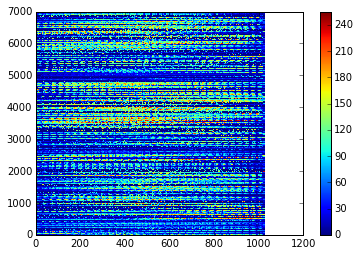

In [11]:
MF_ci = MF * idx_s2
plt.pcolor(MF_ci)
plt.colorbar()

<h3>1.1.1 Selecting a sample</h3>

In [12]:
MFs_ci = MF_ci[:MF_ci.shape[0]/6]
print MFs_ci.shape

(1155, 1024)


<h2>2. Convex-NMF</h2>

In [13]:
import kernel as kernel
import pymf
from pymf.cnmf import CNMF 
import time

In [14]:
#Exploring bases
bases = np.arange(2,MF_ci.shape[1]/16)
fopx = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf = CNMF(MF_ci, item)
    cnmf.factorize(niter=10)
    fopx[idx] = np.linalg.norm(MF - np.dot(cnmf.W,cnmf.H))

min base  12


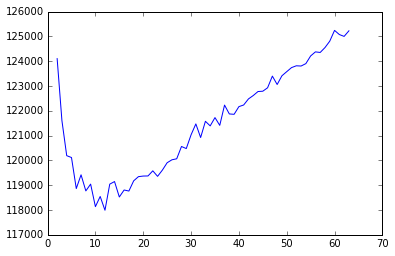

In [15]:
print "min base ", bases[np.argmin(fopx)]
plt.plot(bases,fopx)

In [16]:
cnmf = CNMF(MF_ci, num_bases=12)
cnmf.factorize(niter=10)

<h3>2.1 Kernelization</h3>

<h3>Convex-NMF with Linear kernel</h3>

Exploration of size of latent space is performed over a sample

In [17]:
KlX_ci = kernel._get_kernel(MFs_ci, MFs_ci,'linear')

In [18]:
bases = np.arange(2,KlX_ci.shape[1]/32)
fopxl_ci = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf_kl_ci = CNMF(KlX_ci, item)
    cnmf_kl_ci.factorize(niter=10)
    fopxl_ci[idx] = np.linalg.norm(KlX_ci - np.dot(cnmf_kl_ci.W,cnmf_kl_ci.H))

min base  15


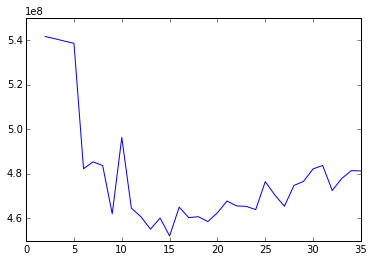

In [19]:
plt.plot(bases,fopxl_ci)
print "min base ", bases[np.argmin(fopxl_ci)]

In [20]:
KlX_ci = kernel._get_kernel(MF_ci, MF_ci,'linear')

In [21]:
cnmf_kl_ci = CNMF(KlX_ci, num_bases=15)
cnmf_kl_ci.factorize(niter=10)
np.linalg.norm(KlX_ci - np.dot(cnmf_kl_ci.W,cnmf_kl_ci.H))

2874033357.9559484

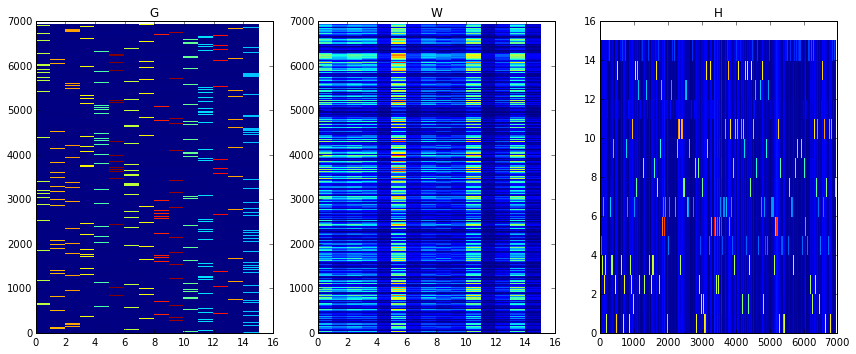

In [22]:
f, axarr = plt.subplots(1, 3)
axarr[0].pcolor(cnmf_kl_ci.G)
axarr[0].set_title('G')
axarr[1].pcolor(cnmf_kl_ci.W)
axarr[1].set_title('W')
axarr[2].pcolor(cnmf_kl_ci.H)
axarr[2].set_title('H')
f.set_size_inches(12,5)
f.tight_layout()

In [23]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 13
preimxkl_ci = np.copy(MF_ci)
tic = time.clock()#get start time
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_kl_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    preimxkl_ci[j], trainErrorskl = kernel.preimage(xs, alpha, 'linear')

toc = time.clock()#get final time
print 'Time: ',toc - tic

10.894055


In [24]:
print "Error: ",np.linalg.norm(MF_ci - preimxkl_ci)

Error:  106544.581977


In [ ]:
#Display completion

<h3>Convex-NMF with Gaussian kernel</h3>

Exploration of size of latent space is performed over a sample

In [55]:
sigma = 1200
KgX_ci = kernel._get_kernel(MFs_ci, MFs_ci,'rbf', gamma=(2*sigma)**-2)

<matplotlib.colorbar.Colorbar instance at 0x7fc684da69e0>

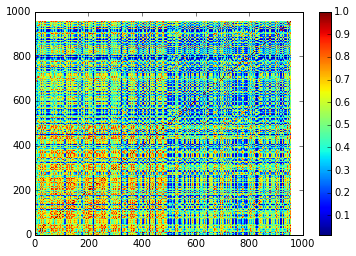

In [56]:
plt.pcolor(KgX_ci[200:,200:])
plt.colorbar()

In [57]:
bases = np.arange(2,KgX_ci.shape[1]/16)
fopxg_ci = np.ones(len(bases))
tic = time.clock()#get start time
for idx,item in enumerate(bases):        
    cnmf_kg_ci = CNMF(KgX_ci, item)
    cnmf_kg_ci.factorize(niter=10)
    fopxg_ci[idx] = np.linalg.norm(KgX_ci - np.dot(cnmf_kg_ci.W,cnmf_kg_ci.H))

toc = time.clock()#get final time
print 'Time: ',toc - tic

Time:  2011.118913


min base  5


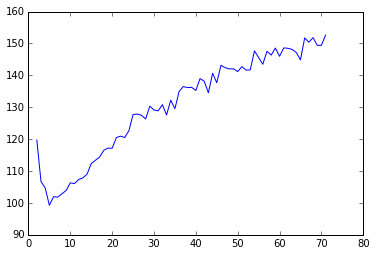

In [58]:
print "min base ", bases[np.argmin(fopxg_ci)]
plt.plot(bases,fopxg_ci)

In [63]:
sigma = 1200
KgX_ci = kernel._get_kernel(MF_ci, MF_ci,'rbf', gamma=(2*sigma)**-2)

In [64]:
#Factorize
cnmf_kg_ci = CNMF(KgX_ci, num_bases=5)
cnmf_kg_ci.factorize(niter=10)
np.linalg.norm(KgX_ci - np.dot(cnmf_kg_ci.W,cnmf_kg_ci.H))

606.65988037220916

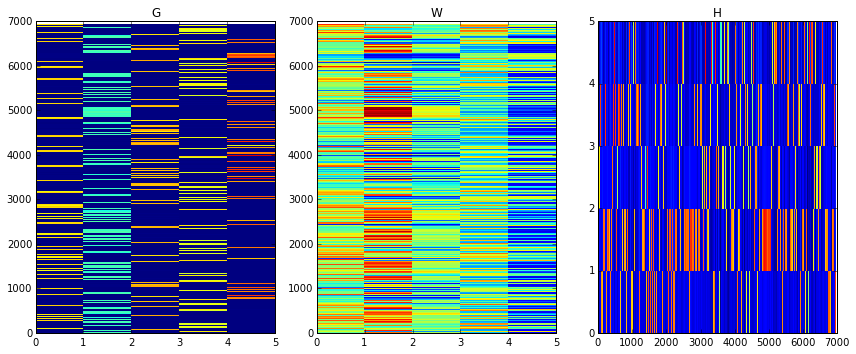

In [65]:
f, axarr = plt.subplots(1, 3)
axarr[0].pcolor(cnmf_kg_ci.G)
axarr[0].set_title('G')
axarr[1].pcolor(cnmf_kg_ci.W)
axarr[1].set_title('W')
axarr[2].pcolor(cnmf_kg_ci.H)
axarr[2].set_title('H')
f.set_size_inches(12,5)
f.tight_layout()

In [66]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 5
preimxkg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_kg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    preimxkg_ci[j], trainErrorskg = kernel.preimage_isot(xs, alpha, 'rbf', gamma=(2*sigma)**-2)

In [67]:
print "Error_ori: ",np.linalg.norm(MF - preimxkg_ci)
print "Error_ci: ",np.linalg.norm(MF_ci - preimxkg_ci)

Error_ori:  127756.1874
Error_ci:  63943.9765811


In [ ]:
#Display completion

<h3>Convex-NMF with Linear x Gaussian kernel</h3>

Exploration of size of latent space is performed over a sample

In [70]:
sigma = 1200
KlxgX_ci = kernel._get_kernel(MFs_ci, MFs_ci,'linxrbf', gamma=(2*sigma)**-2)

In [71]:
bases = np.arange(2,KlxgX_ci.shape[1]/32)
fopxlxg_ci = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf_klxg_ci = CNMF(KlxgX_ci, item)
    cnmf_klxg_ci.factorize(niter=10)
    fopxlxg_ci[idx] = np.linalg.norm(KlxgX_ci - np.dot(cnmf_klxg_ci.W,cnmf_klxg_ci.H))

min base  10


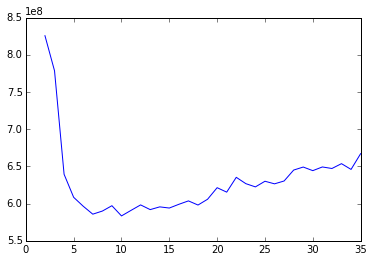

In [72]:
print "min base ", bases[np.argmin(fopxlxg_ci)]
plt.plot(bases,fopxlxg_ci)

In [75]:
sigma = 1200
KlxgX_ci = kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigma)**-2)

In [76]:
#Factorize
cnmf_klxg_ci = CNMF(KlxgX_ci, num_bases=7)
cnmf_klxg_ci.factorize(niter=10)
np.linalg.norm(KlxgX_ci - np.dot(cnmf_klxg_ci.W,cnmf_klxg_ci.H))

3652573680.722826

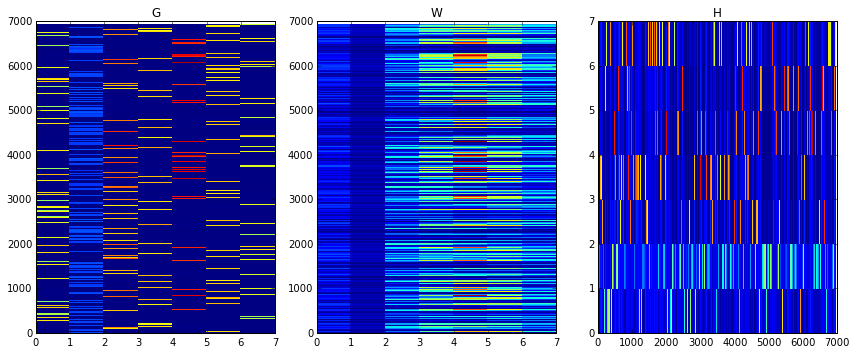

In [77]:
f, axarr = plt.subplots(1, 3)
axarr[0].pcolor(cnmf_klxg_ci.G)
axarr[0].set_title('G')
axarr[1].pcolor(cnmf_klxg_ci.W)
axarr[1].set_title('W')
axarr[2].pcolor(cnmf_klxg_ci.H)
axarr[2].set_title('H')
f.set_size_inches(12,5)
f.tight_layout()

In [81]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 7
preimxklxg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_klxg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    #print j, xs.shape, alpha.shape
    preimxklxg_ci[i], trainErrorskg = kernel.preimage(xs, alpha, 'linxrbf', gamma=(2*sigma)**-2)

In [82]:
print "Error_ori: ",np.linalg.norm(MF - preimxklxg_ci)
print "Error_ci: ",np.linalg.norm(MF_ci - preimxklxg_ci)

Error_ori:  110580.195115
Error_ci:  1938.37547975


In [ ]:
#Display completion

<h3>Convex-NMF with Polynomial x Gaussian kernel</h3>

Exploration of size of latent space is performed over a sample

In [83]:
sigma = 1200
KpxgX_ci = kernel._get_kernel(MFs_ci,MFs_ci,'polyxrbf', gamma=(2*sigma)**-2, degree=2,coef0=1)

<matplotlib.colorbar.Colorbar instance at 0x7fc643fe53f8>

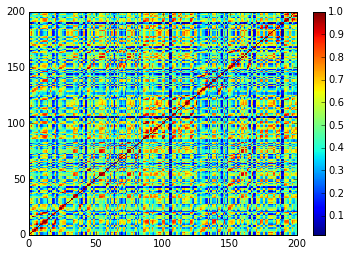

In [90]:
plt.pcolor(KgX_ci[:200,:200])
plt.colorbar()

In [89]:
bases = np.arange(2,KpxgX_ci.shape[1]/16)
fopxpxg_ci = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf_kpxg_ci = CNMF(KpxgX_ci, item)
    cnmf_kpxg_ci.factorize(niter=10)
    fopxpxg_ci[idx] = np.linalg.norm(KpxgX_ci - np.dot(cnmf_kpxg_ci.W,cnmf_kpxg_ci.H))

min base  16


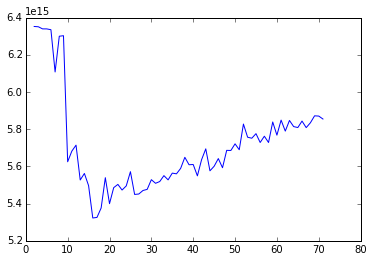

In [91]:
print "min base ", bases[np.argmin(fopxpxg_ci)]
plt.plot(bases,fopxpxg_ci)

In [92]:
#Factorize
cnmf_kpxg_ci = CNMF(KpxgX_ci, num_bases=16)
cnmf_kpxg_ci.factorize(niter=10)
np.linalg.norm(KpxgX_ci - np.dot(cnmf_kpxg_ci.W,cnmf_kpxg_ci.H))

5514023671542391.0

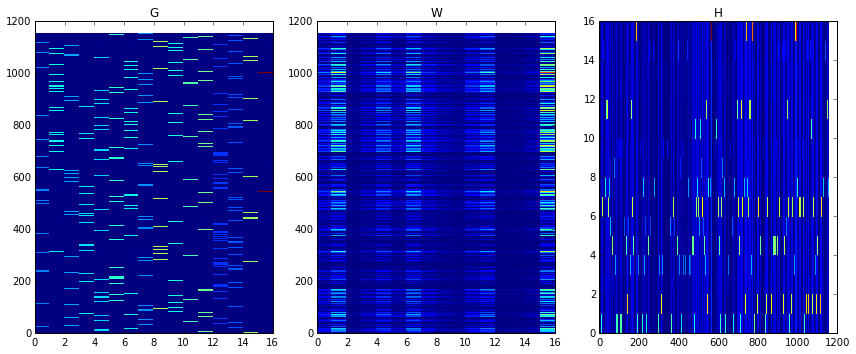

In [93]:
f, axarr = plt.subplots(1, 3)
axarr[0].pcolor(cnmf_kpxg_ci.G)
axarr[0].set_title('G')
axarr[1].pcolor(cnmf_kpxg_ci.W)
axarr[1].set_title('W')
axarr[2].pcolor(cnmf_kpxg_ci.H)
axarr[2].set_title('H')
f.set_size_inches(12,5)
f.tight_layout()

In [103]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 16
preimxkpxg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_kpxg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    print j, xs.shape, alpha.shape
    preimxkpxg_ci[j], trainErrorskpxg = kernel.preimage_isot(xs, alpha, 'polyxrbf', gamma=(2*sigma)**-2, degree=2,coef0=1)

0 (16, 1024) (16,)


AttributeError: 'int' object has no attribute 'T'

In [ ]:
print "Error_ori: ",np.linalg.norm(MF - preimxkpxg_ci)
print "Error_ci: ",np.linalg.norm(MF_ci - preimxkpxg_ci)

In [ ]:
#Display completion

<h3>Computing completion error</h3>

In [106]:
print 'Ori vs. Incomplete', np.linalg.norm(MF[idx_inc] - MF_ci[idx_inc])
print 'without kernel', np.linalg.norm(MF[idx_inc] - np.dot(cnmf.W, cnmf.H)[idx_inc])
print 'Lineal', np.linalg.norm(MF[idx_inc] - preimxkl_ci[idx_inc])
print 'Gaussian', np.linalg.norm(MF[idx_inc] - preimxkg_ci[idx_inc])
print 'Lineal x Gaussian', np.linalg.norm(MF[idx_inc] - preimxklxg_ci[idx_inc])
#print 'Poly x Gaussian', np.linalg.norm(sphere[idx_inc] - preimxkpxg_ci[idx_inc])


Ori vs. Incomplete 110602.040117
without kernel 99692.0482626
Lineal 70258.6942404
Gaussian 127756.1874
Lineal x Gaussian 110580.195115


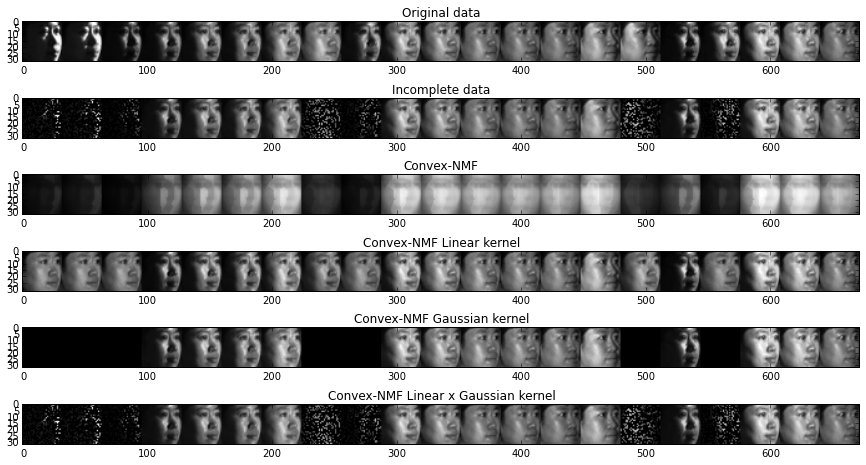

In [150]:
#fig = plt.figure(figsize=(15,12))
f, axarr = plt.subplots(6, 1)
axarr[0].imshow( np.reshape(MF[0:21],(672,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original data')
axarr[1].imshow( np.reshape(MF_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete data')
axarr[2].imshow( np.reshape(np.dot(cnmf.W, cnmf.H)[0:21],(672,32)).T, cmap='Greys_r' )
axarr[2].set_title('Convex-NMF')
axarr[3].imshow( np.reshape(preimxkl_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[3].set_title('Convex-NMF Linear kernel')
axarr[4].imshow( np.reshape(preimxkg_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[4].set_title('Convex-NMF Gaussian kernel')
axarr[5].imshow( np.reshape(preimxklxg_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[5].set_title('Convex-NMF Linear x Gaussian kernel')
f.set_size_inches(15,8)
#plt.imshow( np.reshape(MF[0:21],(672,32)).T, cmap='Greys_r' )

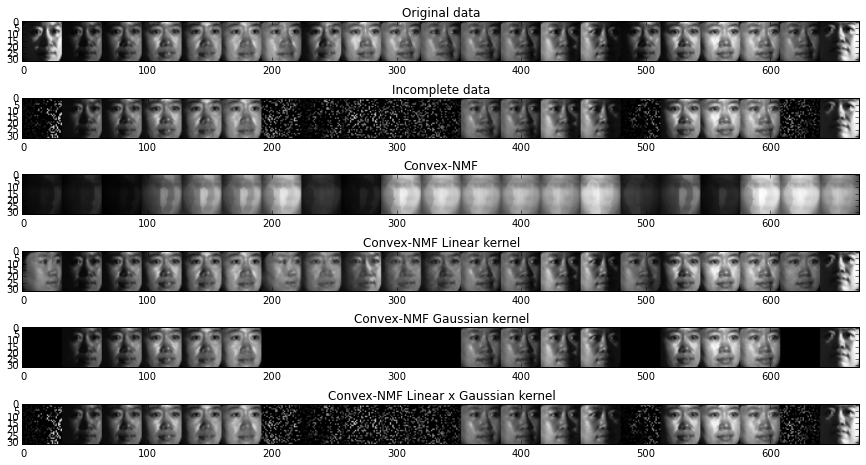

In [157]:
f, axarr = plt.subplots(6, 1)
axarr[0].imshow( np.reshape(MF[22:43],(672,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original data')
axarr[1].imshow( np.reshape(MF_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete data')
axarr[2].imshow( np.reshape(np.dot(cnmf.W, cnmf.H)[0:21],(672,32)).T, cmap='Greys_r' )
axarr[2].set_title('Convex-NMF')
axarr[3].imshow( np.reshape(preimxkl_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[3].set_title('Convex-NMF Linear kernel')
axarr[4].imshow( np.reshape(preimxkg_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[4].set_title('Convex-NMF Gaussian kernel')
axarr[5].imshow( np.reshape(preimxklxg_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[5].set_title('Convex-NMF Linear x Gaussian kernel')
f.set_size_inches(15,8)

In [116]:
print idx_inc[:10]

[ 0  1  2  7  8 15 17 22 28 29]


In [118]:
np.reshape(MF[5],(32,32))

array([[ 6,  6,  6, ..., 12, 14, 14],
       [ 6,  6,  6, ..., 13, 13, 14],
       [ 6,  6,  6, ..., 13, 13, 12],
       ..., 
       [16, 15, 26, ..., 39, 25, 26],
       [13, 17, 15, ..., 21, 28, 27],
       [11, 14, 13, ..., 27, 27, 27]], dtype=uint8)

#2. Compute Online Kernel Matrix Factorization

In [ ]:
from sklearn.metrics import pairwise_kernels as K #to compute kernel matrix
from OKMF import OKMF #Online Kernel Matrix Factorization
from kntf import Kntf

2.1 Computing Online kernel-NMF $\phi(X) \approx \phi(X)WH$ (Esteban algorithm adaptation)

Loss function:

$\min_{W,h_i}\frac{1}{2}||\phi(x_i)-\phi(X)Wh_i||^2+\frac{\lambda}{2}||W||_F^2+\frac{\alpha}{2}||h_i||_F^2$

Algorithm iterate assesing the following updated rules (SGD):

$h_t = (W^T_{t-1}K(X,X)W_{t-1}-\alpha I) W^T_{t-1}K(X,x_t)$

$W_t = W_{t-1}-\gamma(k(X,x_t)h_t^T-k(X,X)W_{t-1}h_th_t^T+\lambda W_{t-1})$

In [43]:
#Parameters:
Gamma = 0.01
Lambda = 0.0001
Alpha = 0.3
sigma = 2**-1

In [44]:
#online kernel NMF algorithm (by Esteban)
ok = OKMF(6930,10,100,2,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
#(budgetSize,latentTopics,minibatchSize,epochs,Gamma,Lambda,Alpha,metric,**kwds):

In [45]:
ok.fit(MF,calculateErrors=True)

Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq


Error:

$2\epsilon = tr(K(x_i,x_i))+tr(h^TW^TK(X,x_i))+tr(K(X,x_i)^TWh)+tr(W^TK(X,X)h^TWh)+\lambda tr(W^TW)+\alpha tr(h^Th)$

In [46]:
ok.trainErrors

array([ -1.69227451e+14,   1.49439136e+30,   1.49418218e+30])

2.2 Compute error as $||WH-\phi(X)||_F/||\phi(X)||_F$

In [21]:
error = np.linalg.norm(np.dot(ok.W,ok.H) ,'fro')/np.linalg.norm(ok._KB,'fro')

SyntaxError: invalid syntax (<ipython-input-21-cacf44931215>, line 1)

In [17]:
print error

0.999999999973


2.3 Parameters' selection

In [ ]:
kf = KFold(X.shape[0],n_folds=4,shuffle=True)

In [ ]:
from time import clock

f = open('../outcomes/Results_cmu_faces.csv','w')
f.write('sigma,Budget,Gamma,Lambda,Alpha,tr0,tr1,tr2,ts0,ts1,ts2,time\n')
c = 0.0
budget = 6930
for exp in [-1,0,1]:
        sigma = 2**exp
        for Gamma in [0.01,0.1,0.8]:
            for Lambda in [0.0001, 0.1,0.3]:
                for Alpha in [0.3,0.4,0.6]:
                    suma0 = 0.0
                    suma1 = 0.0
                    suma2 = 0.0
                    suma3 = 0.0
                    suma4 = 0.0
                    suma5 = 0.0
                    time = 0.0
                    c += 1
                    print 'rbf',(c / 224.0)
                    #for train,test in kf:
                    #    ok = OKMF(budget,10,100,2,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
                    #    t0 = clock()
                    #    ok.fit(X,Xt,True)
                    #    ok.fit(X,calculateErrors=True)
                    #    time += clock() - t0
                    #    suma0 += ok.trainErrors[0]
                    #    suma1 += ok.trainErrors[1]
                    #    suma2 += ok.trainErrors[2]
                    #    suma3 += ok.validationErrors[0]
                    #    suma4 += ok.validationErrors[1]
                    #    suma5 += ok.validationErrors[2]
                    ok = OKMF(budget,10,100,5,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
                    t0 = clock()                    
                    ok.fit(MF,calculateErrors=True)
                    time += clock() - t0
                    suma0 += ok.trainErrors[0]
                    suma1 += ok.trainErrors[1]
                    suma2 += ok.trainErrors[2]
                    suma3 += ok.trainErrors[2]
                    suma4 += ok.trainErrors[2]
                    suma5 += ok.trainErrors[2]
                    suma0/=4.0
                    suma1/=4.0
                    suma2/=4.0
                    suma3/=4.0
                    suma4/=4.0
                    suma5/=4.0
                    time/=4.0
                    val = (sigma,budget,Gamma,Lambda,Alpha)
                    val += (suma0,suma1,suma2,suma3,suma4,suma5,time)
                    s = '{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(*val)
                    f.write(s)
f.close()

In [13]:
param_values = np.genfromtxt('../outcomes/Results_cmu_faces.csv', delimiter=',',skip_header=1)

In [21]:
param_values.shape

(81, 12)

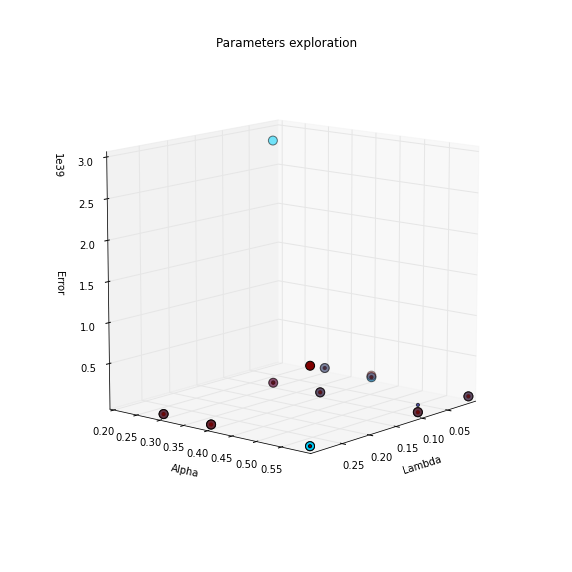

In [42]:
from mpl_toolkits.mplot3d import Axes3D

#fig = plt.scatter(param_values[:,3],param_values[:,4],c=param_values[:,7],s=param_values[:,0])
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

ax.set_title('Parameters exploration')
ax.set_xlabel('Lambda')
ax.set_ylabel('Alpha')
ax.set_zlabel('Error')

ax.set_xlim(0.0001, 0.3)
ax.set_ylim(0.2, 0.6)
ax.set_zlim(2e+29, 3e+39)

ax.view_init(elev=12, azim=40)              # elevation and angle
ax.dist=12                                  # distance

sc = ax.scatter(
           param_values[:,3], param_values[:,4], param_values[:,7],  # data
           c=param_values[:,0],                            # marker colour
           #marker='o',                                # marker shape
           s=(param_values[:,2]*100)                                 # marker size
           )
#plt.colorbar(sc)
plt.show()                                            # render the plot


In [34]:
min(param_values[:,7])

2.12455138591e+29

# Convex Kernel - NMF

In [2]:
from CNMF import CNMF #Source: Esteban Paez
from sklearn import datasets

In [3]:
iris = datasets.load_iris()
iris.data.shape

(150, 4)

In [20]:
splatent = 4
objects = iris.data.shape[0]
#attributes = iris.data.shape[1]
attributes = 150
#X = np.random.rand(objects,attributes)
KX = K(iris.data,iris.data,'linear')
epochs = 2
W0 = np.random.rand(objects,splatent)
G0 = np.random.rand(splatent,attributes)

In [38]:
XP = (abs(KX)+ KX)/2
XN = (abs(KX)- KX)/2
W=W0
G=G0

In [78]:
np.dot(XN,np.dot(W.T,np.dot(G.T,G))).shape

ValueError: shapes (150,150) and (4,150) not aligned: 150 (dim 1) != 4 (dim 0)

In [70]:
n = np.dot(XP,G) + np.dot(XN,np.dot(W,np.dot(G.T,G)))

ValueError: shapes (150,150) and (4,150) not aligned: 150 (dim 1) != 4 (dim 0)

In [79]:
W,G,error = CNMF(iris.data,epochs,W0,G0,calculateErrors = True)

ValueError: shapes (150,4) and (150,4) not aligned: 4 (dim 1) != 150 (dim 0)

In [73]:
#Initialization
splatent = 2
objects = 100
attributes = 3
X = np.random.rand(objects,attributes)
KX = np.dot(X,X.T)
epochs = 2
W0 = np.random.rand(objects,splatent)
G0 = np.random.rand(splatent,attributes)

In [70]:
W,G,error = CNMF(X,epochs,W0,G0,calculateErrors = True)

ValueError: shapes (100,3) and (2,100) not aligned: 3 (dim 1) != 2 (dim 0)

In [76]:
np.dot(X.T,W0)

array([[ 24.58270696,  21.45834436],
       [ 24.18164956,  24.94593442],
       [ 26.30794224,  23.26503157]])